## Problem Statements

The F&B space has witnessed massive growth in the past few years. And with the augment of high competition, restaurants owners are striving hard to be ahead of the other competitors. 

The goal is to conduct sentimental analysis on customers reviews to identify the factors that contributes to the success of a restaurant. And use classification system to determine whether or not a restaurant will be successful.


In [1]:
# import libraries
import pandas as pd    
import matplotlib.pyplot as plt
import matplotlib    
%matplotlib inline
import matplotlib.dates as mdates
import numpy as np

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re
from sklearn.metrics import accuracy_score

from datetime import datetime

import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Load data

In [2]:
user_reviews = pd.read_pickle('./data/user_reviews_final.pkl')

In [3]:
user_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,clean_msg,words,sentiment_dict
0,nJTSr-EGNhhA5o146THkPg,T9O5pkKKlNvr-qqfefDlbA,luOZQ9YBrWwP8mYrS4rNoA,4.0,2,0,0,This place has some of the BEST chinese take-o...,2008-12-03 04:39:26,place best chinese takeout portland dont let i...,49,"[{'label': 'POSITIVE', 'score': 0.997427761554..."
1,lJ7rzbvT-l8KO8lHfEsXsg,LV1ME-ibA2h0IGyFUUWhaQ,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,Incredible donuts. Sometimes you have to go ea...,2017-08-07 19:34:13,incredible donuts sometimes go early full sele...,10,"[{'label': 'POSITIVE', 'score': 0.999814927577..."
2,m-9DK7NwYedIPj1RQ_sXdw,JuM-lH05m6Ln8OPUTg8p0g,H_RM2u1WWGU1HkKZrYq2Ow,5.0,0,0,0,"Dont bother going to voodoo, just come here in...",2016-09-18 17:06:01,dont bother going voodoo come instead unique f...,14,"[{'label': 'NEGATIVE', 'score': 0.877250492572..."
3,EO5rALvJMkK8QEvUNs1gxg,u2xPfv6_wcKt-lW-C1cV8A,9P-lp3AWDXGayDqJz9VPwQ,2.0,0,0,0,The ramen here is less than great. It came out...,2018-02-11 03:30:12,ramen less great came luke warm oily service r...,11,"[{'label': 'POSITIVE', 'score': 0.629967510700..."
4,OH9E5SaGBQsPX3IktM30mg,7mWnNVk2n99JxkvV3PW0nA,Un6u2cECyV4nZb_HGZ-uTA,4.0,1,0,1,It's crazy how establishments on the west coas...,2011-02-13 16:38:09,crazy establishments west coast many yelp revi...,101,"[{'label': 'POSITIVE', 'score': 0.958464384078..."


In [4]:
user_reviews.shape

(2282305, 12)

In [5]:
# Check missing value
user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2282305 entries, 0 to 2282304
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   review_id       object 
 1   user_id         object 
 2   business_id     object 
 3   stars           float64
 4   useful          int64  
 5   funny           int64  
 6   cool            int64  
 7   text            object 
 8   date            object 
 9   clean_msg       object 
 10  words           int64  
 11  sentiment_dict  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 209.0+ MB


In [6]:
restaurants = pd.read_pickle('./data/restaurants_cleaned.pkl')

In [7]:
restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,garage,lot,street,valet,validated,RestaurantsAttire,NoiseLevel,WiFi,Alcohol,sentiment_final
0,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,...,True,False,False,False,False,casual,2,Free,beer_and_wine,0.366400
1,HPA_qyMEddpAEtFof02ixg,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,...,False,True,False,False,False,casual,2,Free,NaN,0.132592
2,jGennaZUr2MsJyRhijNBfA,Legal Sea Foods,1 Harborside Dr,Boston,MA,02128,42.363442,-71.025781,3.5,856,...,True,False,False,False,False,casual,2,Free,full_bar,0.090394
3,iPD8BBvea6YldQZPHzVrSQ,Espresso Minute,334 Mass Ave,Boston,MA,02115,42.342673,-71.084239,4.5,7,...,False,False,False,False,False,casual,1,NaN,NaN,0.655234
4,jx91IMdGOmLOo8h_F9z39g,Cleary's Restaurant & Spirits,12429 NE Glisan St,Portland,OR,97230,45.526473,-122.535323,3.5,19,...,False,True,False,False,False,casual,2,No,full_bar,-0.114162


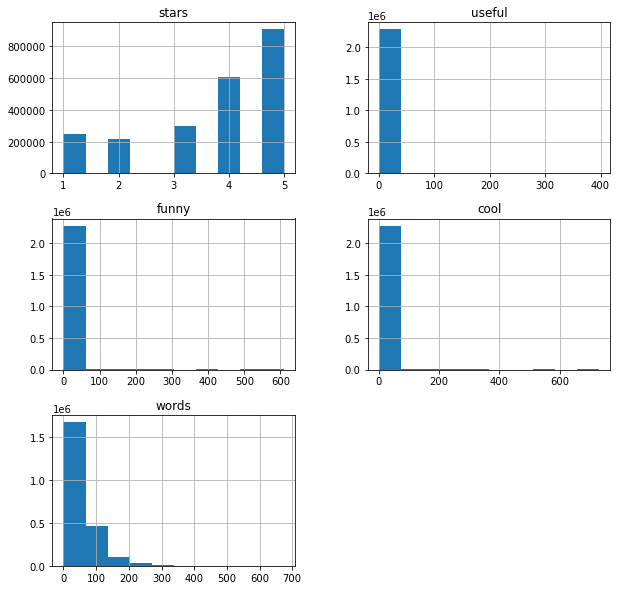

In [8]:
user_reviews.hist(figsize=(10, 10));

In [9]:
## Extract reviews with words > 5 and useful > 1 reviews only
user_reviews = user_reviews[(user_reviews['words'] >5) & (user_reviews['useful'] > 1) ]

In [10]:
user_reviews

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,clean_msg,words,sentiment_dict
0,nJTSr-EGNhhA5o146THkPg,T9O5pkKKlNvr-qqfefDlbA,luOZQ9YBrWwP8mYrS4rNoA,4.0,2,0,0,This place has some of the BEST chinese take-o...,2008-12-03 04:39:26,place best chinese takeout portland dont let i...,49,"[{'label': 'POSITIVE', 'score': 0.997427761554..."
16,Zul1x6eu4VPaqwVOdiTuqg,-zqGTvnQt9IFgTsUvuYcSw,lyhNDfX8UatlRO5H3Kfccg,5.0,4,2,2,As many people before have said I shall too sa...,2015-09-23 23:14:02,many people said shall say best persian kabobs...,64,"[{'label': 'POSITIVE', 'score': 0.805905520915..."
19,ggecU8oSt68aGEuiEDloAA,uQSBQI8hKuNRxyxhPUsgLw,7EbGTD7ZF30vEFBiHyN_0A,2.0,2,0,0,I don't remember McCormick and Schmick's food ...,2013-10-03 08:52:29,dont remember mccormick schmicks food extremel...,46,"[{'label': 'NEGATIVE', 'score': 0.993262350559..."
24,6CywkXcek4au_vNBYnaA2w,3ZCS3niZj8GjbZY6Dx7uqw,qTutBN2eY81xLz3TeGWAzA,5.0,5,1,2,I was getting my hair cut across the street wh...,2015-12-20 20:04:21,getting hair cut across street told bbq place ...,75,"[{'label': 'NEGATIVE', 'score': 0.952830374240..."
27,7Wj4vkKzhzSJlNkIB-bNew,QSlUBNjrG0PjeRuWc3V9Mw,kGmMiW1qCoJ95-5Y9Vk8kw,4.0,3,3,3,Went here last Sunday for brunch with a group ...,2014-09-09 19:07:54,went last sunday brunch group 4 able get right...,88,"[{'label': 'NEGATIVE', 'score': 0.964251935482..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2282287,lBrDngWns5w5t8cSPlgPtw,pN7qHvZUKtVzwFfWx65-4A,0Iva7qdGwb_Vv596pUdRtQ,5.0,2,1,2,As I consider myself a professional ...,2017-09-13 17:43:25,consider professional italian eater tough job ...,187,"[{'label': 'POSITIVE', 'score': 0.996143817901..."
2282292,rQR3eFuRer7EhTFIQ_sFhA,mc-8J8nybr6Ru66DHLZemw,bYVkqQFIMWngr86n1xW37Q,3.0,2,0,0,"I'm conflicted on the place. On the one hand,...",2012-10-02 14:12:01,im conflicted place one hand love love love pi...,183,"[{'label': 'NEGATIVE', 'score': 0.982932686805..."
2282293,I8EBfO5eiZe9QUxfZ8DnrQ,ODSH1it5oAUPu2clIgOvyg,5Vo5jygrgCXNgaNbH86e7g,3.0,2,0,1,Came here on a Thursday night. The first thing...,2012-08-24 23:24:33,came thursday night first thing irked first ca...,86,"[{'label': 'NEGATIVE', 'score': 0.991434097290..."
2282294,xOKZtdlHm_2_tXtyvWooHg,qCK8CsFqIaIm009HmY2PIg,z0wY9e7HV6NMBM1xSCyxNg,1.0,9,7,3,A beautiful catastrophe. \n\nAfter hearing (an...,2017-08-02 18:57:32,beautiful catastrophe hearing reading rave rev...,453,"[{'label': 'NEGATIVE', 'score': 0.981755375862..."


In [11]:
user_agg = user_reviews.groupby('user_id').agg({'review_id':['count'],
                                'useful':['sum'],'funny':['sum'],'cool':['sum'],
                               'stars':['mean']})

In [12]:
user_agg=user_agg.sort_values([('review_id','count')],ascending=False)
print("          Top 10 Users in Yelp")
user_agg.head(10)

          Top 10 Users in Yelp


,review_id,useful,funny,cool,stars
,count,sum,sum,sum,mean
user_id,,,,,
Pf7FI0OukC_CEcCz0ZxoUw,835,10312,5646,6932,4.021557
8lEywHSvti2UjFP8ODbnHg,713,8362,3050,5814,3.483871
rcU7ysY41qGppbw4pQgjqg,673,5758,4859,4020,3.815750
wkrFqNxwTEEkG3mJV88Izw,564,3339,2246,2331,3.686170
nl8gWLDo6U6MjqzbBmE_9A,510,1649,443,584,3.531373
3i48mMo0ydcfJd1-7_Iieg,508,2171,601,1582,4.433071
CUU_SVpheVGIilr5kUaJ1Q,471,1923,620,1251,3.774947
z9B25fKtfrxzUws_OOHJSQ,468,4213,2146,3144,3.641026


In [13]:
import matplotlib.gridspec as gridspec 
import seaborn as sns


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


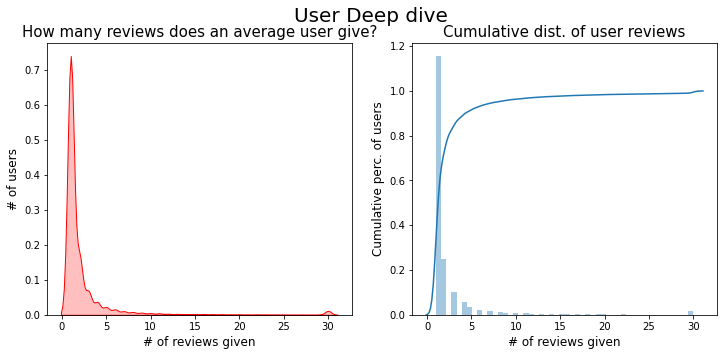

NameError: name 'time' is not defined

In [15]:
# Cap max reviews to 30 for better visuals
user_agg[('review_id','count')].loc[user_agg[('review_id','count')]>30] = 30
plt.figure(figsize=(12,5))
plt.suptitle("User Deep dive",fontsize=20)
gridspec.GridSpec(1,2)
plt.subplot2grid((1,2),(0,0))
#Cumulative Distribution
ax=sns.kdeplot(user_agg[('review_id','count')],shade=True,color='r')
plt.title("How many reviews does an average user give?",fontsize=15)
plt.xlabel('# of reviews given', fontsize=12)
plt.ylabel('# of users', fontsize=12)

#Cumulative Distribution
plt.subplot2grid((1,2),(0,1))
sns.distplot(user_agg[('review_id','count')],
             kde_kws=dict(cumulative=True))
plt.title("Cumulative dist. of user reviews",fontsize=15)
plt.ylabel('Cumulative perc. of users', fontsize=12)
plt.xlabel('# of reviews given', fontsize=12)

plt.show()
end_time=time.time()
print("Took",end_time-start_time,"s")

## Tokenization and Bag-of-Words (BoW)

Transform text data into numeric form and Bag-of-words 

In [48]:
from nltk import FreqDist

In [21]:
# concatenate all the reviews into one single string 
full_text = ' '.join(user_reviews['clean_msg'])

In [22]:
word_tokens = word_tokenize(full_text)

In [23]:
token_dist = FreqDist(word_tokens)
dist = pd.DataFrame(token_dist.most_common(20),columns=['Word', 'Frequency'])

In [24]:
dist

,Word,Frequency
0,food,400131
1,good,321938
2,place,317888
3,like,259140
4,one,220711
5,get,200852
6,great,194451
7,time,181649
8,service,177225
9,really,177187


## TF-IDF 

Term Frequency - Inverse document frequency. TF-IDF gives a numerical weightage of words to reflect the important of particular word in a corpus.

### N-Grams

In [30]:
## def fuction to calculate the trigram frequency

def ngram(df,n_range):
    tvec = TfidfVectorizer(max_features= 1_000,ngram_range=(n_range,n_range))
    ngrams = tvec.fit_transform(df['clean_msg'])    
    ngram_df = pd.DataFrame(ngrams.toarray(), columns=tvec.get_feature_names())
    ngram_frequency = pd.DataFrame(ngram_df.sum(axis=0)).reset_index()
    ngram_frequency.columns = ['ngram', 'frequency']
    ngram_frequency = ngram_frequency.sort_values(by='frequency', ascending=False).head(100)
    
    return ngram_frequency
    

In [154]:
def treemap(df,size):
    #cmap=matplotlib.cm.GnBu
    cmap=matplotlib.cm.RdGy
    #Normalize based on Frequency
    norm = matplotlib.colors.Normalize(vmin=df.frequency.min(), vmax=df.frequency.max())
    
    #Define colors array
    colors=[cmap(norm(i)) for i in df.frequency]
    
    plt.figure(figsize=(20,20))
    labels = list(df['ngram'].iloc[8:size])
    sizes = list(df['frequency'].iloc[8:size])
    squarify.plot(sizes, label = labels, alpha=0.7,edgecolor="white", linewidth=3,color=colors,
                 text_kwargs={'color':'black', 'size':16})
    plt.axis('off')
    plt.show()

In [90]:
trigram_user_reviews = ngram(user_reviews,3)

In [62]:
trigram_user_reviews

,ngram,frequency
112,cant go wrong,1910.094615
631,never go back,1538.126681
965,would come back,1514.023475
176,definitely come back,1509.545693
974,would go back,1509.341057
...,...,...
352,french onion soup,526.489023
604,make sure get,526.355161
899,vanilla ice cream,522.982422
789,service good food,519.935763


### Bi-gram for 1 star reviews

In [19]:
import squarify

In [20]:
df_bad = user_reviews[user_reviews['stars'] <= 1]

In [40]:
bigram_1_star = ngram(df_bad,2)

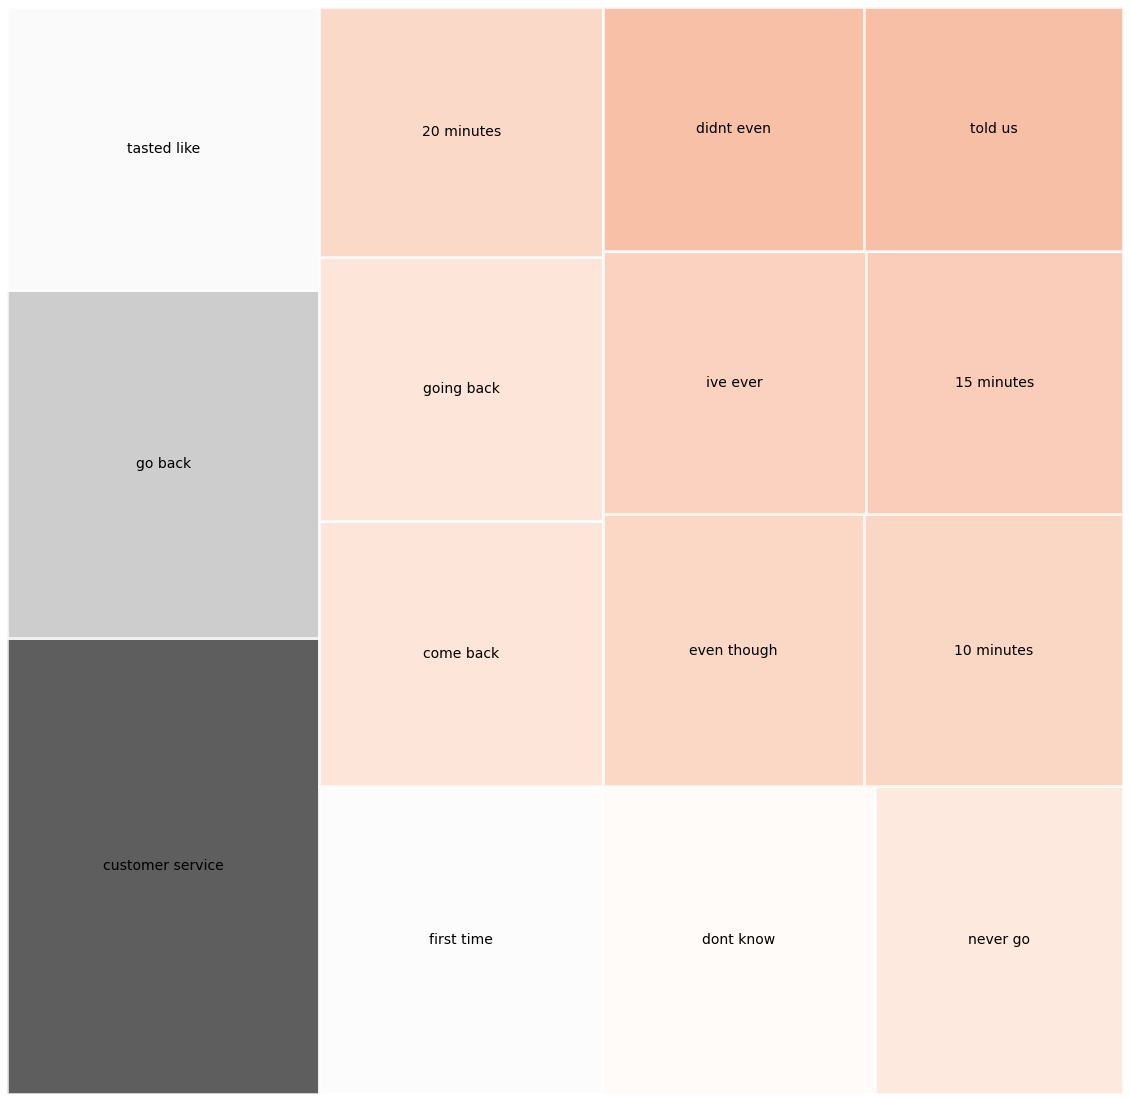

In [115]:
treemap(bigram_1_star,15)

### Tri-gram for 1 star reviews

In [31]:
trigram_1_star = ngram(df_bad,3)

In [32]:
trigram_1_star.head()

,ngram,frequency
585,never go back,991.595309
260,dont waste time,403.610154
578,never come back,403.386629
587,never going back,387.300521
941,wont going back,376.502950


### Plot Treemap for Tri-gram 1 star reviews

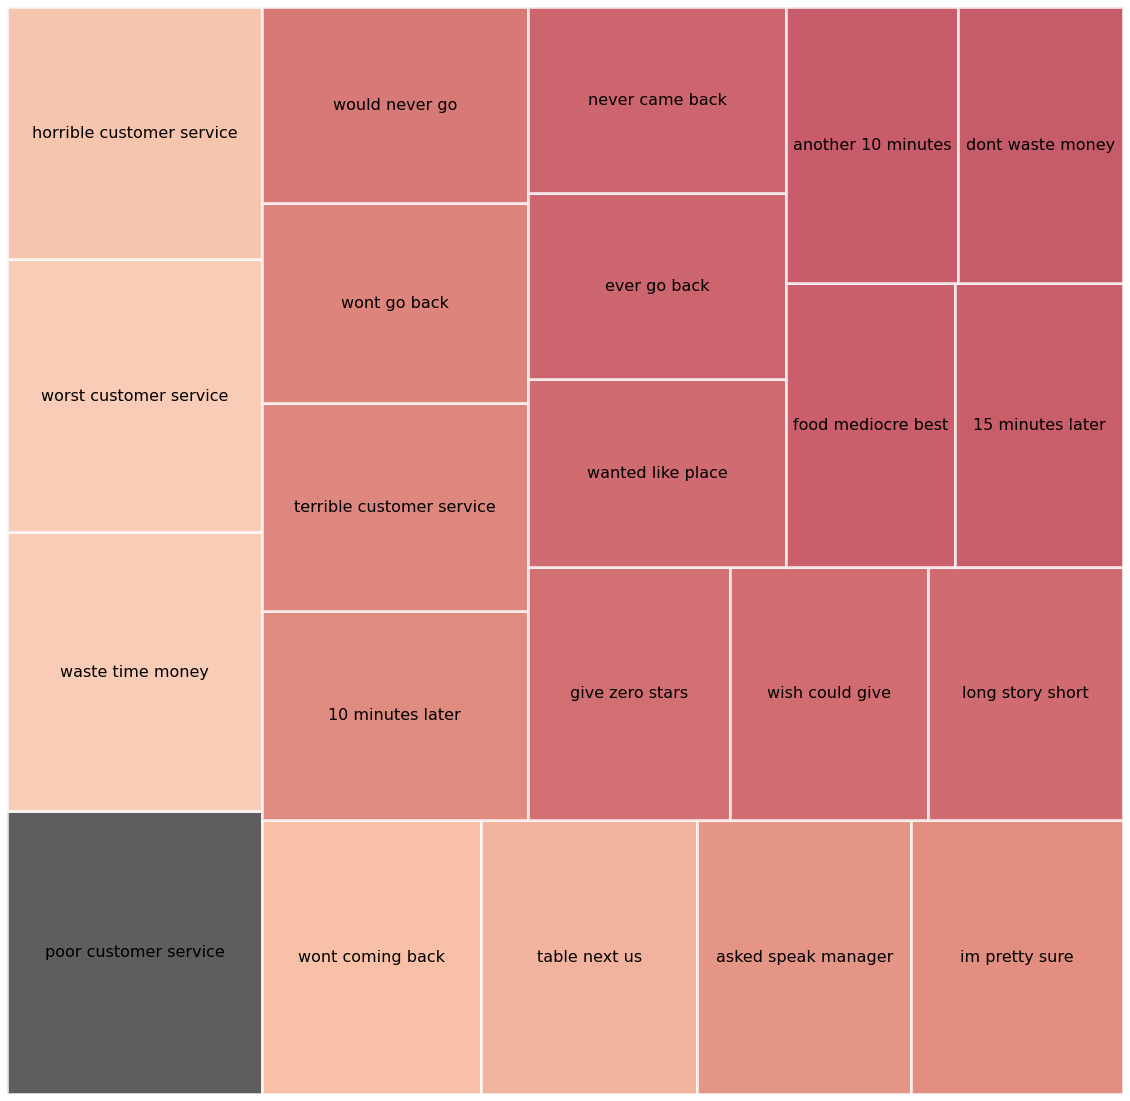

In [155]:
treemap(trigram_1_star,30)

### Bi-gram for 4 stars above reviews

In [19]:
df_good = user_reviews[user_reviews['stars'] >= 4]

In [ ]:
bigram_4_star = ngram(df_good,2)

In [137]:
treemap(bigram_4_star,30)

NameError: name 'bigram_4_star' is not defined

### Tri-gram for 4 stars above reviews

In [112]:
trigram_5_star = ngram(df_good,3)

In [138]:
trigram_5_star

,ngram,frequency
115,cant go wrong,1599.752029
936,wait go back,1370.367884
123,cant wait go,1360.130597
180,definitely come back,1308.086634
70,best ive ever,1233.538403
...,...,...
953,well definitely back,313.492589
251,every single time,310.186201
682,one best meals,309.113954
991,would recommend place,306.405790


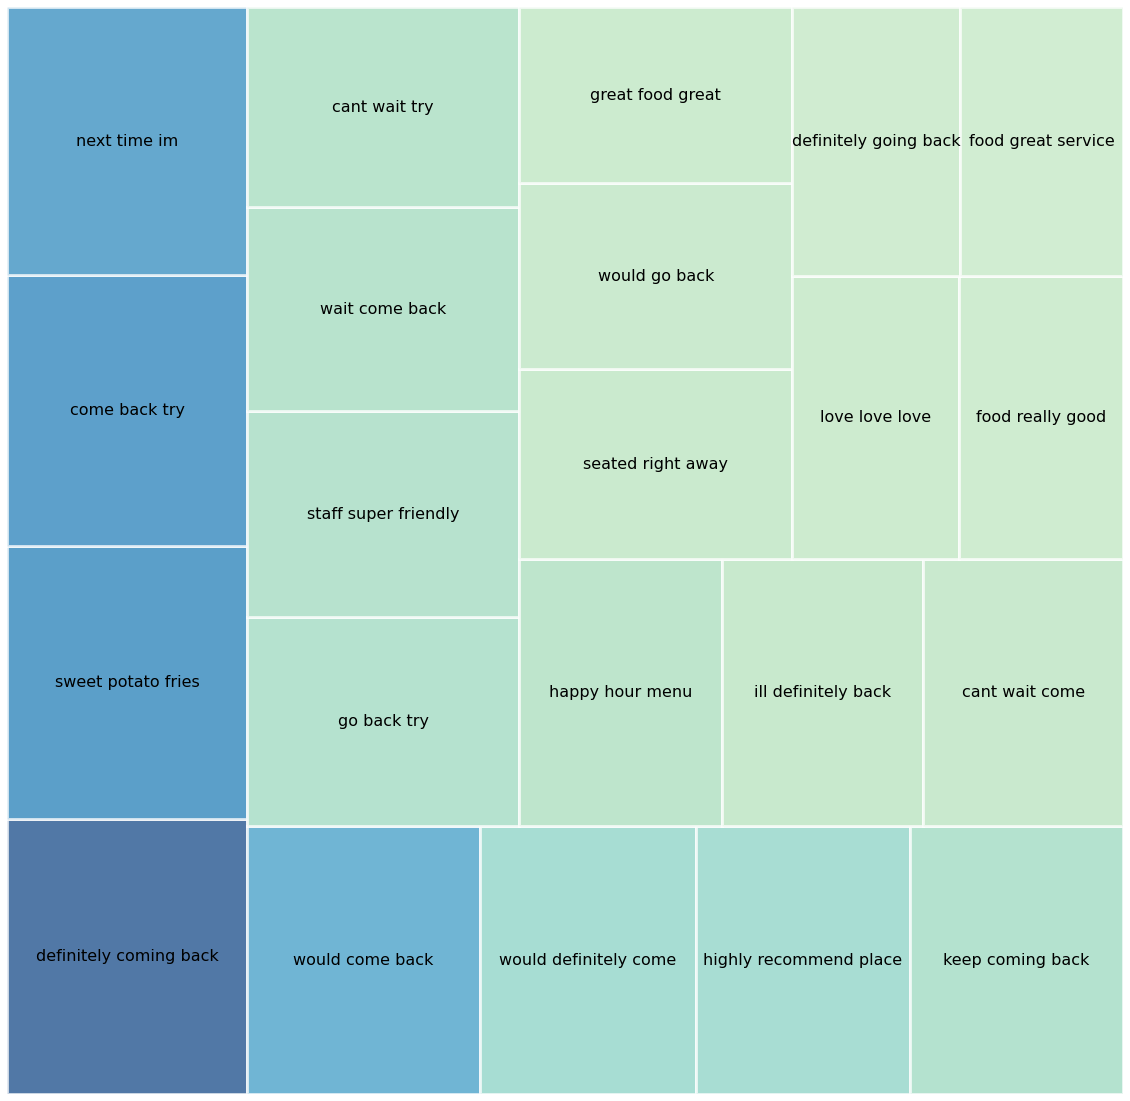

In [153]:
treemap(trigram_5_star,22)

## Word Embedding 

### Why people love it

In [14]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [15]:
#pip install dataframe-image
import dataframe_image as dfi

Use Word2Vec model to see what are the words that are most likely around the target words, such as fries, burgers, service.

In [16]:
# create function to tokenize the reviews
def review_lines(df):
    review_lines = list()
    lines = df['clean_msg'].values.tolist()
    
    for line in lines:
        tokens = word_tokenize(line)
        review_lines.append(tokens)
    
    return review_lines

In [17]:
# create function to predict the output word and convert to dataframe table

def predict_output(model,word, topn):
    pred = model.predict_output_word([word], topn=topn)
    pred_table = pd.DataFrame(pred, columns=['word', 'probability'])
    
    return pred_table

In [21]:
good_review_lines = review_lines(df_good)

In [22]:
model_good_reviews = Word2Vec(sentences=good_review_lines, window=5, min_count=1, workers=4, sg=0)

In [223]:
predict_service = predict_output(model_good_reviews,'service',6)
print(predict_service)

dfi.export(predict_service, './img/predict_service_5.png')

         word  probability
0  impeccable     0.419132
1      prompt     0.386828
2      spotty     0.077133
3    customer     0.075028
4   attentive     0.030484
5    friendly     0.002074


In [230]:
predict_price = predict_output(model_good_reviews,'price',6)
print(predict_price)

dfi.export(predict_price, './img/predict_price_5.png')

         word  probability
0         tag     0.849519
1  reasonable     0.150423
2    moderate     0.000023
3       lower     0.000018
4       steep     0.000005
5  unbeatable     0.000005


In [229]:
predict_staff = predict_output(model_good_reviews,'staff',8)
predict_staff

dfi.export(predict_staff, './img/predict_staff_5.png')

In [245]:
predict_food = predict_output(model_good_reviews,'food',6)
print(predict_food)

dfi.export(predict_food, './img/predict_food_5.png')

        word  probability
0       coma     0.303693
1      court     0.044934
2     trucks     0.030591
3     indian     0.030038
4    comfort     0.023506
5  allergies     0.022847


In [201]:
predict_time = predict_output(model_good_reviews,'time')
predict_time

,word,probability
0,next,0.767293
1,every,0.182118
2,longest,0.007651
3,first,0.006355
4,frame,0.005200
5,warp,0.004815
6,last,0.004446
7,2nd,0.003732
8,1st,0.002872
9,spent,0.000808


## Bad reviews word2vec

In [23]:
bad_review_lines = review_lines(df_bad)

In [24]:
model_bad_reviews = Word2Vec(sentences=bad_review_lines, window=5, min_count=1, workers=4, sg=0)

In [254]:
predict_service = predict_output(model_bad_reviews,'service',6)
print(predict_service)

dfi.export(predict_service, './img/predict_service_1.png')

         word  probability
0    customer     0.301797
1        poor     0.229803
2   atrocious     0.110427
3        slow     0.109642
4  deplorable     0.060949
5     abysmal     0.033704


In [269]:
predict_price = predict_output(model_bad_reviews,'price',6)
print(predict_price)

dfi.export(predict_price, './img/predict_price_1.png')

         word  probability
0         tag     0.906590
1      higher     0.082279
2  exorbitant     0.002630
3  outrageous     0.001566
4  reasonable     0.001303
5       steep     0.001096


In [262]:
predict_staff = predict_output(model_bad_reviews,'staff',10)
print(predict_staff)


dfi.export(predict_staff, './img/predict_staff_1.png')

          word   probability
0       member  8.957837e-01
1      members  1.042160e-01
2        train  1.088223e-07
3         wait  5.236794e-08
4     friendly  5.085982e-08
5      trained  4.501265e-08
6    untrained  8.361844e-09
7         hire  6.647711e-09
8  incompetent  3.034652e-09
9   unfriendly  2.832359e-09


In [268]:
predict_food = predict_output(model_bad_reviews,'food',6)
print(predict_food)



dfi.export(predict_food, './img/predict_food_1.png')

        word  probability
0  poisoning     0.538474
1      court     0.059331
2    quality     0.019930
3   mediocre     0.014952
4  allergies     0.009028
5      truck     0.008439


In [208]:
predict_time = predict_output(model_bad_reviews,'time')
predict_time

,word,probability
0,wasting,0.265274
1,every,0.140420
2,waste,0.131859
3,last,0.104262
4,3rd,0.095696
5,2nd,0.051259
6,third,0.045628
7,frame,0.030828
8,second,0.029216
9,next,0.019460


### Visualizaing Bad Review Word2Vec Vectors

In [25]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

In [26]:
def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    #plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


In [27]:
words = []
embeddings = []
for word in list(model_bad_reviews.wv.vocab):
    embeddings.append(model_bad_reviews.wv[word])
    words.append(word)
    
tsne_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_2d = tsne_2d.fit_transform(embeddings)

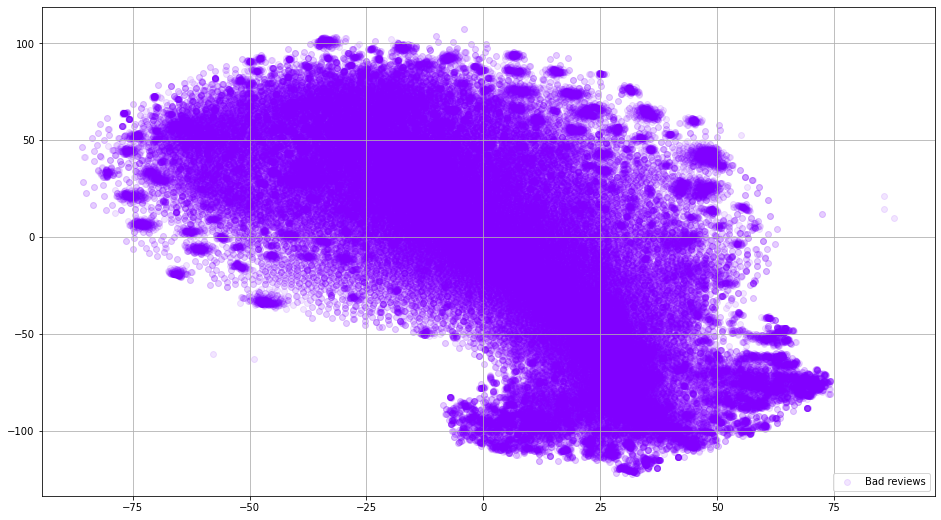

In [28]:
tsne_plot_2d('Bad reviews', embeddings_2d, a=0.1)

### Visualizaing Good Review Word2Vec Vectors

In [ ]:
words = []
embeddings = []
for word in list(model_good_reviews.wv.vocab):
    embeddings.append(model_good_reviews.wv[word])
    words.append(word)
    
tsne_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_2d = tsne_2d.fit_transform(embeddings)

In [ ]:
tsne_plot_2d('Good reviews', embeddings_2d, a=0.1)

## Top Positive and negatives words by category

### Merge restaurants category and business_id with review
 
 

In [11]:
restaurants_reviews = pd.merge(restaurants, user_reviews, on = 'business_id')

In [12]:
## update column names
restaurants_reviews.rename(columns={'stars_x':'avg_star','stars_y':'review_star'}, inplace=True)

In [13]:
restaurants_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,...,user_id,review_star,useful,funny,cool,text,date,clean_msg,words,sentiment_dict
0,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,...,gQMsoHpjmzBmBQkkefrLXw,5.0,2,0,1,"Other than my own store, this is my go-to airp...",2016-08-12 23:47:28,store goto airport restaurant last four years ...,41,"[{'label': 'POSITIVE', 'score': 0.996586203575..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,...,Ri1nrLjmtQoDLnULZal3PA,5.0,7,4,5,On the way to my flight I stopped here for bre...,2010-12-01 07:07:09,way flight stopped breakfast far best option a...,18,"[{'label': 'NEGATIVE', 'score': 0.998925507068..."
2,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,...,HFECrzYDpgbS5EmTBtj2zQ,4.0,6,3,5,I usually have low expectations regarding Airp...,2011-11-05 02:25:19,usually low expectations regarding airport foo...,118,"[{'label': 'POSITIVE', 'score': 0.994164884090..."
3,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,...,aX7kWaGXzQhNXrWyAmG9iQ,3.0,3,2,0,Summary: Go to Stanford's - it's way better a...,2013-08-09 02:39:29,summary go stanfords way better worth effort r...,222,"[{'label': 'NEGATIVE', 'score': 0.988239526748..."
4,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,...,bDq3dF80FddzS80Syr7y1A,4.0,3,2,3,"I mean, I wouldn't go out of my way to drive o...",2015-07-30 18:44:21,mean wouldnt go way drive pdx flying elephants...,40,"[{'label': 'NEGATIVE', 'score': 0.954494774341..."


In [14]:
import csv

In [15]:
## import positive file which contains common meaningless positive words such as good
file_positive = open('./data/positive.txt')
reader =csv.reader(file_positive)
positive_words = [word[0] for word in reader]

## import negative file which contains common meaningless positive words such as bad
file_negative = open('./data/negative.txt')
reader =csv.reader(file_negative)
negative_words = [word[0] for word in reader]

In [16]:
## get dataset by category
def get_dataset(category):
    df = restaurants_reviews[['clean_msg']][restaurants_reviews.category==category]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'clean_msg':'text'}, inplace=True)
    return df


## only keep positive and negative words
def filter_words(review):
    words = [word for word in review.split() if word in positive_words + negative_words]
    words = ' '.join(words)
    return words

In [63]:
korean_reviews = get_dataset('Korean')

In [64]:
korean_reviews

,text
0,know expect got expect tables get cray yet ant...
1,three us arrived location around 715 pm saturd...
2,head heels love place starters love good hole ...
3,limit 3 orders time group 7 gave us portion ev...
4,rude lady almost old came told us close 10 lea...
...,...
8756,owner unethical charges price different menu f...
8757,cute little spot grab beer bibimbap looking sp...
8758,food okay little pricey small korean restauran...
8759,disappointed ill never go back food first time...


In [65]:
print('Total %d number of reviews' % korean_reviews.shape[0])

Total 8761 number of reviews


In [59]:
korean_reviews.text = korean_reviews.text.apply(filter_words)

In [66]:
# concatenate all the reviews into one single string 
full_text = ' '.join(korean_reviews['text'])

In [67]:
word_tokens = word_tokenize(full_text)

In [68]:
from nltk.probability import FreqDist

In [69]:
token_dist = FreqDist(word_tokens)
dist = pd.DataFrame(token_dist.items(),columns=['Word', 'Frequency'])

In [70]:
dist

,Word,Frequency
0,know,1701
1,expect,396
2,got,2752
3,tables,783
4,get,4110
...,...,...
30637,scientists,1
30638,tewksbury,1
30639,httpwwwgreenteacafetewksburycom,1
30640,ls27,1


In [29]:
#!pip install spacy spacytextblob --user
#!python -m spacy download en_core_web_sm

In [71]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

In [72]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

In [73]:
dist['polarity'] = dist['Word'].apply(lambda word: nlp(word)._.polarity)

In [74]:
dist

,Word,Frequency,polarity
0,know,1701,0.0
1,expect,396,0.0
2,got,2752,0.0
3,tables,783,0.0
4,get,4110,0.0
...,...,...,...
30637,scientists,1,0.0
30638,tewksbury,1,0.0
30639,httpwwwgreenteacafetewksburycom,1,0.0
30640,ls27,1,0.0


In [75]:
test = dist.sort_values(by='polarity',ascending=False)

In [76]:
## calculate polarity score 
test['polarity_score'] = test.polarity * test.Frequency / test.shape[0]


In [2]:
test.sort_values(by='polarity_score', ascending=False).head(40)

NameError: name 'test' is not defined

In [124]:
from transformers import pipeline

In [125]:
sentiment = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are 

In [126]:
dist['sentiment_dict'] = dist['Word'].apply(lambda review: sentiment(review, truncation=True))

dist

<ipython-input-126-b52d4aa1b2d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist['sentiment_dict'] = dist['Word'].apply(lambda review: sentiment(review, truncation=True))


,Word,Frequency,sentiment_dict
0,slow,344,"[{'label': 'NEGATIVE', 'score': 0.999731361865..."
1,friendly,1158,"[{'label': 'POSITIVE', 'score': 0.999840736389..."
2,yay,45,"[{'label': 'POSITIVE', 'score': 0.914097726345..."
3,drunk,92,"[{'label': 'NEGATIVE', 'score': 0.999730646610..."
4,fun,430,"[{'label': 'POSITIVE', 'score': 0.999875664710..."
...,...,...,...
2792,thrill,3,"[{'label': 'POSITIVE', 'score': 0.999797523021..."
2828,tremendously,3,"[{'label': 'POSITIVE', 'score': 0.999881625175..."
2918,fraud,3,"[{'label': 'NEGATIVE', 'score': 0.999453008174..."
2935,bunk,5,"[{'label': 'NEGATIVE', 'score': 0.996479928493..."


### Create New column for distilbert analysis 'label'

In [127]:
dist['sentiment_label'] = dist['sentiment_dict'].apply(lambda score_dict: score_dict[0]['label'])

<ipython-input-127-f01313c59da6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist['sentiment_label'] = dist['sentiment_dict'].apply(lambda score_dict: score_dict[0]['label'])


In [128]:
## Label POSITIVE = 1 , NEGATIVE = -1

dist['sentiment_label'].replace({'POSITIVE': 1, 'NEGATIVE': -1},inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Create New column for distilbert analysis 'score'

In [129]:
dist['sentiment_score'] = dist['sentiment_dict'].apply(lambda score_dict: score_dict[0]['score'])

<ipython-input-129-f1dc0ee48131>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist['sentiment_score'] = dist['sentiment_dict'].apply(lambda score_dict: score_dict[0]['score'])


# Multiply sentiment_label * sentiment_score to get compound score.
user_reviews_final['sentiment_final'] = user_reviews_final['sentiment_label'] * user_reviews_final['sentiment_score']

In [130]:
dist

,Word,Frequency,sentiment_dict,sentiment_label,sentiment_score
0,slow,344,"[{'label': 'NEGATIVE', 'score': 0.999731361865...",-1,0.999731
1,friendly,1158,"[{'label': 'POSITIVE', 'score': 0.999840736389...",1,0.999841
2,yay,45,"[{'label': 'POSITIVE', 'score': 0.914097726345...",1,0.914098
3,drunk,92,"[{'label': 'NEGATIVE', 'score': 0.999730646610...",-1,0.999731
4,fun,430,"[{'label': 'POSITIVE', 'score': 0.999875664710...",1,0.999876
...,...,...,...,...,...
2792,thrill,3,"[{'label': 'POSITIVE', 'score': 0.999797523021...",1,0.999798
2828,tremendously,3,"[{'label': 'POSITIVE', 'score': 0.999881625175...",1,0.999882
2918,fraud,3,"[{'label': 'NEGATIVE', 'score': 0.999453008174...",-1,0.999453
2935,bunk,5,"[{'label': 'NEGATIVE', 'score': 0.996479928493...",-1,0.996480


dist2 = dist.sort_values(['sentiment_label', 'sentiment_score','Frequency'],
              ascending = [True, True, False])

In [131]:
dist_positive = dist[dist['sentiment_label'] == 1]

In [132]:
dist_positive = dist_positive.sort_values(by='sentiment_score', ascending=False)

In [139]:
dist2 = dist_positive.sort_values(by=['Frequency'],
              ascending = [False])

In [143]:
dist2.head(30)

,Word,Frequency,sentiment_dict,sentiment_label,sentiment_score
5,good,6956,"[{'label': 'POSITIVE', 'score': 0.999816119670...",1,0.999816
44,like,5697,"[{'label': 'POSITIVE', 'score': 0.991056442260...",1,0.991056
12,great,3618,"[{'label': 'POSITIVE', 'score': 0.999863028526...",1,0.999863
46,well,2334,"[{'label': 'POSITIVE', 'score': 0.999570310115...",1,0.999570
69,pretty,2266,"[{'label': 'POSITIVE', 'score': 0.999818980693...",1,0.999819
14,fried,2139,"[{'label': 'POSITIVE', 'score': 0.715533494949...",1,0.715533
20,delicious,2132,"[{'label': 'POSITIVE', 'score': 0.999874234199...",1,0.999874
118,nice,1970,"[{'label': 'POSITIVE', 'score': 0.999855279922...",1,0.999855
31,best,1845,"[{'label': 'POSITIVE', 'score': 0.999794185161...",1,0.999794
22,love,1798,"[{'label': 'POSITIVE', 'score': 0.999873518943...",1,0.999874


In [141]:
unuseful_positive_words = ['bliss','happiness','vibrant','enjoying','']

In [155]:
common_positive_words = ['good', 'like','great','nice','well','love','favorite','super','right','happy','excellent','perfect','awesome','top','better','best','liked']

In [156]:
test = dist_positive_sort[~dist_positive_sort.Word.isin(common_positive_words)]

In [157]:
test.sort_values(by='Frequency', ascending=False).head(30)['Word']

25      delicious
47         pretty
19          fried
1        friendly
41            hot
43          fresh
114       amazing
6       recommend
23          sweet
70          worth
34         enough
112        decent
71          clean
264     authentic
51          loved
90        enjoyed
102          fast
153     attentive
82          enjoy
4             fun
109          work
133       variety
172     fantastic
79           free
130          fine
22      perfectly
117          soft
104    reasonable
168        tender
217          cool
Name: Word, dtype: object